# Laboratorul 6 - Segmentare Semantica

## Intro 

Task-ul pentru acest laborator consta in implementarea si antrenarea unei retele complet convolutionale ([Fully Convolutional Networks](https://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Long_Fully_Convolutional_Networks_2015_CVPR_paper.pdf)) folosita pentru segmentarea semantica a imaginilor (clasificare la nivel de pixel). 

Tema voastra este sa implementati cele 3 variante ale arhitecturii (FCN-32s, FCN-16s si FCN-8s) si sa antrenati retelele pentru a clasifica fiecare pixel din imagine. Pentru aceste exercitii se va folosi detul de date [Kitti Road](http://www.cvlibs.net/datasets/kitti/eval_road.php), unde scopul este sa obtinem segmentarea semantica a drumurilor. 



## De ce FCN?

O retea convolutionala normala consta dintr-o serie de straturi convolutionale, urmata de straturi fully connected si, in cele din urma, de o functie de activare Softmax. Aceasta este o arhitectura buna pentru clasificare, insa straturile fully connected nu pastreaza informatia spatiala. Avantajul retelei FCN este ca aceasta pastreaza informatia spatiala in intreaga retea (FCN functioneaza cu imagini de orice dimensiune).

Din punct de vedere structural, FCN este compusa din doua parti: encoder (blocuri de downsampling - [VGG](https://arxiv.org/pdf/1409.1556.pdf))  si decoder (blocuri de upsampling - o arhitectura "skip" care combina informatie semantica globala (din ultimele straturi "deep" ale retelei) cu informatii de aspect (mai fine, din layerele mai "shallow") pentru a produce segmentari cat mai precise si detaliate). 
Segmentarea semantică se confruntă cu o tensiune inerentă între semantică și locație: informațiile globale rezolva problema clasei - "CE" (clasificare in cazul mai multor clase semantice), în timp ce informațiile locale rezolvă "UNDE". 

---

![alt text](https://www.researchgate.net/publication/324787148/figure/fig4/AS:619840926670848@1524793001425/FCN-VGG16-network-with-skip-architecture.png)

##Descarcarea setului de date 

In [ ]:
!mkdir ./data ./runs ./saved_models
# Download and unzip the dataset
!wget --progress=bar:force https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip -P ./data
!unzip -q ./data/data_road.zip -d ./data

# Pregatirea setului de date

In celula de mai jos sunt implementate clasele de tipul torch.utils.data.Dataset ce vor fi folosite pentru a itera prin seturile de date de antrenare si de test din Kitti Road Segmentation. 

De asemenea sunt implementate doua functii *collate_fn()* una pentru antrenare ce returneaza si imagini si adnotari, si una pentru testare ce returneaza doar imagini.

In final sunt instantiate 3 obiecte torch.utils.data.DataLoader: unul pentru antrenare, unul pentru testare si unul pentru vizualizare.




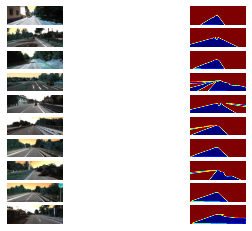

In [ ]:
import os
import glob

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms.functional import normalize, to_tensor

%matplotlib inline

TRAIN_IMAGES_PATH = "./data/data_road/training/image_2"
TRAIN_LABELS_PATH = "./data/data_road/training/gt_image_2"
TEST_IMAGES_PATH = "./data/data_road/testing/image_2"


def collate_fn_train(examples):

  images = []
  labels = []
  for example in examples:
    image, label = example

    image = to_tensor(image)
    image = normalize(image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # normalize the image tensor to [-1, 1] on each channel: img_norm = (img - data_mean) / data_std 
    image = image.unsqueeze(0) 
    label = torch.tensor(label).unsqueeze(0)
    images.append(image)
    labels.append(label)
  
  images_batch = torch.cat(images)
  labels_batch = torch.cat(labels)

  return images_batch, labels_batch

def collate_fn_test(examples):
  images = []
  for example in examples:
    image = example
    image = to_tensor(image)
    image = normalize(image, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # on test set we apply the same normalization 
    image = image.unsqueeze(0)
    images.append(image)

  images_batch = torch.cat(images)

  return images_batch

class KittiImageDataset(Dataset):

  def __init__(self, images_root, original_shape=(1242, 375) ,
               load_shape=(384, 128)):
    self.images_root = images_root
    self.original_shape = original_shape
    self.load_shape = load_shape
    self.images = list(sorted(glob.glob(os.path.join(TRAIN_IMAGES_PATH ,'*'))))

  def __getitem__(self, idx):
    image = cv2.imread(self.images[idx])
    image = cv2.resize(image, self.load_shape)

    return image

  def __len__(self):
    return len(self.images)

class KittiTrainDataset(KittiImageDataset):

  def __init__(self, images_root, labels_root, original_shape=(1242, 375) ,
               load_shape=(384, 128)):
    super(KittiTrainDataset, self).__init__(images_root, original_shape=original_shape, 
                                            load_shape=load_shape)
    self.labels_root = labels_root
    self.labels = list(sorted(glob.glob(os.path.join(TRAIN_LABELS_PATH, '*_road_*'))))

  def __getitem__(self, idx):
    image = super(KittiTrainDataset, self).__getitem__(idx)
    label = cv2.imread(self.labels[idx])
    label = cv2.resize(label, self.load_shape, interpolation=cv2.INTER_NEAREST)  # resize labels to same 'load_shape' as the image
    # Initially label images are RGB images with the following color code: the road (lane) as magenta, non-road areas as red and other road surfaces as black
    # For our project we are interested in black and magenta areas, so we will process the label images by summing over the channel dimension in order to obtain
    # a binary image, where "1" denotes background and "0" denotes the road areas. 
    new_label = label.sum(axis=2) 
    new_label = np.where(new_label == 255, 1, 0)
    
    return image, new_label

  def __len__(self):
    assert len(self.images) == len(self.labels)
    return len(self.images)

# Create train dataset object
train_dataset = KittiTrainDataset(TRAIN_IMAGES_PATH, TRAIN_LABELS_PATH)

# Create test dataset object
test_dataset = KittiImageDataset(TEST_IMAGES_PATH)

# Create dataloaders for visualization, train and test
vis_dataloader = DataLoader(train_dataset, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, 
                              num_workers=2, collate_fn=collate_fn_train)
test_dataloader = DataLoader(test_dataset, shuffle=True, collate_fn=collate_fn_test)


num_samples = 10 
vis_iter = iter(vis_dataloader)
for i in range(num_samples):
  image, label = vis_iter.next()
  image = image.squeeze(0).numpy()
  label = label.squeeze(0).numpy()
  plt.subplot(num_samples, 2, 2*i+1)
  plt.axis('off')
  plt.imshow(image, None)
  plt.subplot(num_samples, 2, 2*i+2)
  plt.axis('off')
  plt.imshow(label[:,:], 'jet')

# Implementarea Retelei FCN

Arhitectura contine:
 * un encoder VGG folosit pentru operatia de downsampling (este un exemplu excelent pentru transferul de cunoștințe (transfer learning) din rețele moderne de clasificare, cum ar fi VGG16, Alexnet, etc. pentru a efectua segmentarea semantică; acest encoder este initializat cu weight-urile preantrenate pe Imagenet).
 * una sau mai multe operatii de upsample (convolutii transposed)
 * skip connections intre blocurile de downsampling si upsampling

## Cerinta
Task-ul vostru este sa implementati cele 3 clase care reprezinta cele 3 variante ale FCN: FCN-32s, FCN-16s si FCN-8s. (asa cum se regaseste in imaginea de mai sus).



 **Hint:** 
  * Folositi imaginea de mai sus a arhitecturii ca referinta 
  * Folosind SelectiveSequential, putem extrage activari intermediare din encoder. Layer-ul '16' este MaxPool3, '23' este MaxPool4 iar '30' este MaxPool5 (corespunzator imaginii arhitecturii FCN)
  * Output-ul encoder-ului nostru este Maxpool5 (puteti ignora portiunea dintre conv6 si conv8, sunt necesare operatii extra pentru a transforma layere Fully-Connected in Convolutions - nu este in scopul acestui laborator)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

class SelectiveSequential(nn.Module):
  def __init__(self, to_select, modules_dict):
    """Helper class - pentru extragea activarilor intermediare"""
    super(SelectiveSequential, self).__init__()
    for key, module in modules_dict.items():
      self.add_module(key, module)
    self._to_select = to_select
  
  def forward(self, x):
    list = []
    for name, module in self._modules.items():
      x = module(x)
      if name in self._to_select:
        list.append(x)
    return list


class FCN(nn.Module):
  """Main FCN Class"""
  def __init__(self):
    """Constructor

    Encoder-ul folosit pentru aceasta arhitectura este VGG16. 
    Pentru a implementa skip connections vom avea nevoie de activari intermediare
    (dupa pool3, pool4 si ultimul layer convolutional al encoder-ului)
    """
    super(FCN, self).__init__()
    vgg16 = models.vgg16(pretrained=True) # Incarca VGG16 (pretrained) din torchvision
    vgg16_convs = list(vgg16.children())[:-2] # Eliminam layerele de care nu avem nevoie 

    # Cele 3 layers ale caror feature maps le vom folosi la skip-connections 
    self.encoder = SelectiveSequential(['16', '23', '30'], vgg16_convs[0]._modules)


class FCN32(FCN):
  def __init__(self):
    super(FCN32, self).__init__()
    #### Codul vostru
    # self.upsample32 = ... 
    
  def forward(self, img):
    # Extrageti feature-uri din encoder de la layerul corespunzator si treceti rezultatul prin layerul de upsample
    #### Codul vostru

    pass


class FCN16(FCN):
  def __init__(self, variant='None'):
    super(FCN16, self).__init__()
    #### Codul vostru
    # self.upsample2 = ...
    # self.upsample16 = ...

  def forward(self, img):
      pass


class FCN8(FCN):
  def __init__(self, variant='None'):
    super(FCN8, self).__init__()
    #### Codul vostru
    # self.upsample2 = ...
    # self.upsample4 = ...
    # self.upsample32 = ...
    
  def forward(self, img):
    #### Codul vostru
    pass

# Antrenarea retelei

In [ ]:
fcn = FCN32().cuda()
stop = 0

import torch.optim as optim

num_epochs =  10#@param
learning_rate = 0.0003 #@param

# Initializam functia de loss
loss_fn = nn.CrossEntropyLoss()

# Initializam optimizatorul
optimizer = optim.Adam(fcn.parameters(), lr=learning_rate)
optimizer.zero_grad()

# Antrenarea retelei
for epoch in range(num_epochs):
  for idx, (image, label) in enumerate(train_dataloader):
    pred = fcn(image.cuda())
    loss = loss_fn(pred, label.cuda())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if idx % 10 == 0:
      print("Epoch {} - Iter {} - Loss {}".format(epoch, idx, loss.item()))

# Rularea retelei pe setul de date de test si vizualizare

## Cerinta
 * Procesati iesirea retelei pentru a vizualiza masca de segmentare prezisa ca in celula pentru pregatirea setului de date.

**Hints**
 * Iesirea va fi un feature map de dimensiunea imaginii de intrare cu 2 canale.
 * Pentru fiecare pixel canalele trebuiesc transformate intr-o distributie de probabilitati (Softmax)
 * Transformati intr-o imagine cu un singur canal cu valori 255 pentru clasa 'road' si 0 pentru clasa 'background'

In [ ]:
fcn.eval() # set model in eval mode

num_to_show = 10

softmax = nn.Softmax(dim=1)
# Ne asiguram ca nu se pot propaga gradienti prin retea
with torch.no_grad():
  for idx, image in enumerate(test_dataloader):

    if idx > num_to_show:
      break

    logits = fcn(image.cuda()) 

    # Postprocesarea imaginii pentru a fi vizualizata
    image = (image.squeeze(0).clone().cpu().numpy().transpose(1, 2, 0) + 1) / 2.0

    #### Codul vostru aici - postprocesarea iesirii retelei pentru a 
    #### fi vizualizata
    # pred = ...
    
    # Cod de vizualizare
    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(image)
    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(pred)
    
    
